In [1]:
import abc
import typing as tp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Загрузка данных, предобработка.

In [2]:
tag = pd.read_csv('tag.csv')
rating = pd.read_csv('rating.csv')
movies = pd.read_csv('movie.csv')
genome_scores = pd.read_csv('genome_scores.csv')
# link = pd.read_csv('link.csv')
genome_tag = pd.read_csv('genome_tags.csv')

In [3]:
def get_log_info(log, user_id='userId', movie_id='movieId'):
    print(f'Длина лога: {log.shape[0]},\nКоличество пользователей: {log[user_id].nunique()},\nКоличество фильмов: {log[movie_id].nunique()}')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [6]:
get_log_info(rating)

Длина лога: 20000263,
Количество пользователей: 138493,
Количество фильмов: 26744


In [7]:
tag.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [8]:
get_log_info(tag)

Длина лога: 465564,
Количество пользователей: 7801,
Количество фильмов: 19545


Объединим данные по рейтингам и фильмам в одну таблицу для удобства.

In [9]:
df = rating.merge(movies, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995),Adventure|Children|Fantasy


Упорядочим id пользователей и фильмов - понадобится для LightFM.

In [10]:
from sklearn.preprocessing import LabelEncoder
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
user_encoder.fit(df['userId'].values)
movie_encoder.fit(df['movieId'].values)
df['userId'] = user_encoder.transform(df['userId'])
df['movieId'] = movie_encoder.transform(df['movieId'])

In [11]:
get_log_info(df)

Длина лога: 20000263,
Количество пользователей: 138493,
Количество фильмов: 26744


Посмотрим на распредление оценок, а также на число оценок по пользователям и по книгам. 

In [12]:
df['rating'].value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

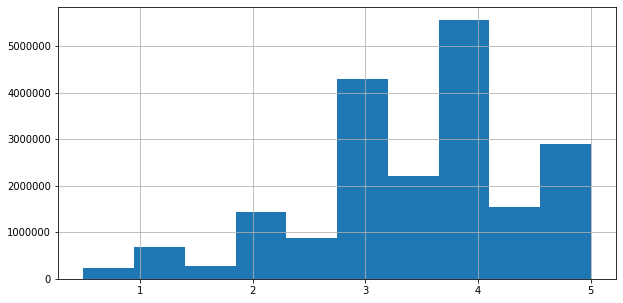

In [13]:
df['rating'].hist(bins=10, figsize=(10, 5))

Видим, что пользователи в целом не очень охотно ставят низкие (меньше 3) оценки. Но и самую высокую оценку 5 ставят тоже не так часто.

In [14]:
def group_by_and_plot(df, group_by_name, rating_col_name, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(0.98)].plot(kind='hist', bins=50, figsize=(10, 5), title=title)
    return grouped

count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
5%           21.000000
25%          35.000000
50%          68.000000
75%         155.000000
95%         520.000000
max        9254.000000
Name: rating, dtype: float64


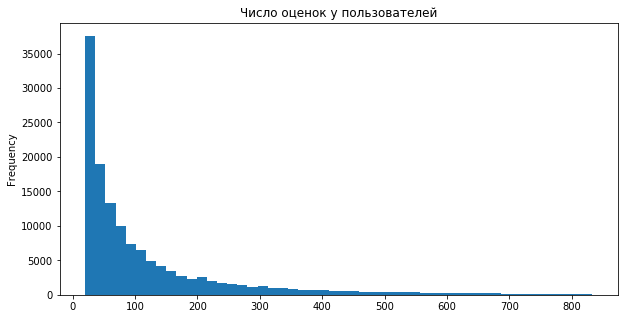

In [15]:
user_count = group_by_and_plot(df, 'userId', 'rating', 'Число оценок у пользователей')

count    26744.000000
mean       747.841123
std       3085.818268
min          1.000000
5%           1.000000
25%          3.000000
50%         18.000000
75%        205.000000
95%       3612.950000
max      67310.000000
Name: rating, dtype: float64


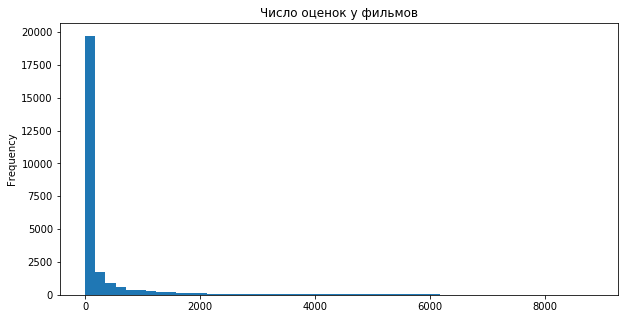

In [16]:
movie_count = group_by_and_plot(df, 'movieId', 'rating', 'Число оценок у фильмов')

Итого, действия со стороны пользователей вполне удовлетворительные - у всех хотя бы 20 отзывов, у половины не менее 68 отзывов. С фильмами немного хуже - есть много фильмов с совсем маленьким количеством отзывов. Учитывать их при рекомендации было бы не очень хорошо, поэтому оставим только те фильмы, у которых есть хотя бы 5 отзывов.

In [17]:
%%time
movie_counts = df.groupby('movieId')['rating'].count()
movies_to_preserve = movie_counts[movie_counts >= 5]
df = df[df['movieId'].isin(movies_to_preserve.index)]

Wall time: 6.69 s


In [18]:
get_log_info(df)

Длина лога: 19984024,
Количество пользователей: 138493,
Количество фильмов: 18345


# 1. Вопрос - как определять успех?

Перед тем, как идти дальше, надо принять важное решение - как мы будем определять, успешна наша рекомендация ("праильная" ли она) или нет? В идеальном случае, можно было бы выдавать каждому пользователю упорядоченный список фильмов для просмотра, а дальше смотреть, какие оценки он им поставил, и исходя из этого как-то мерить качество. Но это сложно, и мы поступим проще - сведем весь спектр впечатлений от просмотра фильма к бинарной переменной - понравился пользователю фильм или нет. Что значит, что фильм понравился? Это довольно субъективный вопрос, и на него нет единственно правильного ответа. Однако, позволим себе предположить, что фильм пользователю понравился, если тот поставил ему оценку 4 и выше. С точки зрения здравого смысла это довольно логичное предположение, а также оно логично исходя из распределения рейтингов.
\
\
Итого, оставим в датасете только те действия, где была поставлена оценка 4 и выше. Далее, предалагая пользователю какой-то набор фильмов, будем смотреть, какие из них ему понравились - то есть какие из них он посмотрел и поставил им хорошую оценку.

In [19]:
%%time
df = df[df['rating'] >= 4.0]

Wall time: 2.37 s


count    138287.000000
mean         72.252316
std         102.110392
min           1.000000
5%            9.000000
25%          19.000000
50%          37.000000
75%          84.000000
95%         249.000000
max        3168.000000
Name: rating, dtype: float64


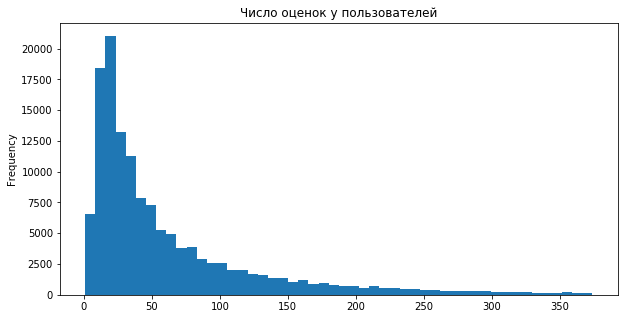

In [20]:
user_count = group_by_and_plot(df, 'userId', 'rating', 'Число оценок у пользователей')

count    17679.000000
mean       565.165224
std       2310.810876
min          1.000000
5%           1.000000
25%          5.000000
50%         27.000000
75%        185.000000
95%       2677.100000
max      55807.000000
Name: rating, dtype: float64


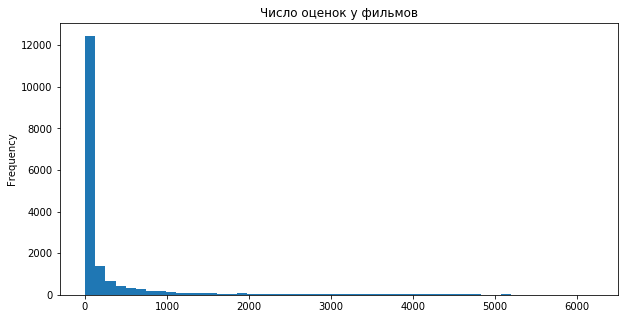

In [21]:
movie_count = group_by_and_plot(df, 'movieId', 'rating', 'Число оценок у фильмов')

Теперь у нас уже появились не очень активные пользователи (то есть жо этого они ставили почти одни плохие оценки, но таким пользователям и предлагать что-то сложно) и фильмы, которым поставили мало хороших оценок (но такие фильмы вряд ли имеет большой смысл предлагать кому-то - они во-первых не очень известные, а во-вторых, судя по всему плохие).
\
Уберем пользователей, оставивших менее 10 отзывов, и фильмы, которые были оценены менее 5 раз.

In [22]:
%%time
movie_counts = df.groupby('movieId')['rating'].count()
user_counts = df.groupby('userId')['rating'].count()
movies_to_preserve = movie_counts[movie_counts >= 5]
users_to_preserve = user_counts[user_counts >= 10]
df = df[df['movieId'].isin(movies_to_preserve.index)]
df = df[df['userId'].isin(users_to_preserve.index)]

Wall time: 8.01 s


In [23]:
get_log_info(df)

Длина лога: 9926677,
Количество пользователей: 129794,
Количество фильмов: 13681


# 2. Разбиение данных на обучение и валидацию.

Будем разбивать данные по времени - на старых действиях пользователей будем обучаться, на новых - тестировать модель. Так стоит делать, чтобы не заглядывать в будущее. Отведем 70% датафрейма на трейн, 30% - на тест (возьмем с запасом, потому что дальше тест будет прилично обрезаться).
\
Также для нашего удобства и для адекватного качества оставим в тесте только активных пользователей. Что такое активный пользователь, определим ниже исходя из распределения числа отзывов в тесте.

In [24]:
%%time
df.loc[:, 'timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S")

Wall time: 12.7 s


In [25]:
%%time
border_time = df['timestamp'].quantile(0.7)
df_train = df[df['timestamp'] <= border_time]
df_test = df[df['timestamp'] > border_time]

Wall time: 960 ms


In [26]:
get_log_info(df_train)

Длина лога: 6948674,
Количество пользователей: 94587,
Количество фильмов: 8868


In [27]:
get_log_info(df_test)

Длина лога: 2978003,
Количество пользователей: 40314,
Количество фильмов: 13303


count    129794.000000
mean         76.480246
std         103.628062
min           8.000000
5%           12.000000
25%          21.000000
50%          41.000000
75%          89.000000
95%         256.350000
max        3150.000000
Name: rating, dtype: float64


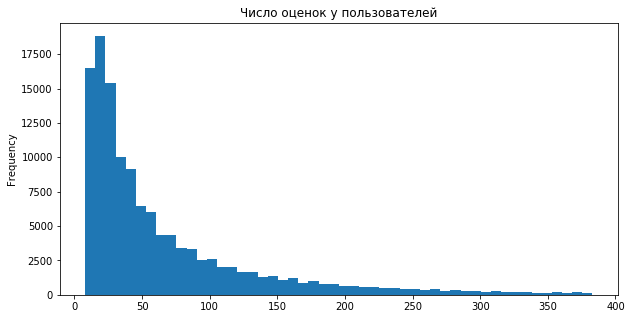

In [28]:
user_test_count = group_by_and_plot(df, 'userId', 'rating', 'Число оценок у пользователей')

В целом, выглядит неплохо, отзывов достаточно. Однако, есть пользователи, которые в тесте оставили огрмное количество отзывов. С такими работать не очень удобно. Здесь сделаем довольно сильное огрубление - оставим в тесте только тех пользователей, которые посмотрели (теперь это значит посмотрели и поставили хорошую оценку) хотя бы 10 фильмов, и среди просмотренных ими фильмов оставим только первые 10 по вхождению.

In [29]:
%%time
users_test_count = df_test.groupby('userId')['movieId'].count()
users_test_to_preserve = users_test_count[users_test_count >= 10]

df_test = df_test[df_test['userId'].isin(users_test_to_preserve.index)]
df_test['rank'] = df_test.groupby('userId')['timestamp'].rank(method="first", ascending=True)
df_test = df_test[df_test['rank'] <= 10].drop('rank', axis=1)

Wall time: 5.95 s


Также удалим из теста пользователей, которых нет в трейней - непонятно, как рекомендовать что-то человеку, который ни с чем не взаимодействовал.

In [30]:
df_test = df_test[df_test['userId'].isin(df_train['userId'].unique())]

In [31]:
get_log_info(df_test)

Длина лога: 39520,
Количество пользователей: 3952,
Количество фильмов: 4747


In [32]:
test_users = pd.Series(df_test['userId'].unique())

# 3. Метрики качества.

Для сравнения моделей, которые мы далее будем строить, будем использовать несколько метрик. Это типичные для ранжирования метрики HitRate и MeanAveragePrecision, а также более нестандартные метрики Coverage и Surprisal, отвечающие за разнообразие наших рекомендаций.
\
Для подсчета метрик я использую библиотеку `rs_metrics`, подробно о ней и о используемых метриках можно посмотреть [здесь](https://darel13712.github.io/rs_metrics/).
\
\
Напишем функцию, которая будет считать все 4 метрики для предсказания, и выводить их в удобном формате. Так как мы каждому пользователю будем рекомендовать 10 фильмов (об этом далее), то все метрики будем считать `@10`. Основной метрикой будем считать MeanAveragePrecision (`map@10`).

In [33]:
# !pip install rs_metrics
from rs_metrics import hitrate, mapr, coverage, surprisal

In [34]:
def print_metrics(pred, true, model_name, unique_items=df['movieId'].unique(), log=df, metrics_df=None):
    user_col = 'userId'
    item_col = 'movieId'
    K = 10    # can be changed
    if metrics_df is None:
        metrics_df = pd.DataFrame(columns=['hit_rate@10', 'map@10', 'coverage@10', 'surprisal@10'])
    
    metrics_df.loc[model_name, 'hit_rate@10'] = hitrate(true, pred, k=K, user_col=user_col, item_col=item_col)
    metrics_df.loc[model_name, 'map@10'] = mapr(true, pred, k=K, user_col=user_col, item_col=item_col)
    metrics_df.loc[model_name, 'coverage@10'] = coverage(unique_items, pred, k=K, user_col=user_col, item_col=item_col)
    metrics_df.loc[model_name, 'surprisal@10'] = surprisal(log, pred, k=K, user_col=user_col, item_col=item_col)
    
    return metrics_df

# 4. Общий класс для моделей.

Напишем родительский класс для дальнейшего использования различных моделей - потом просто будем переопределять его методы `fit` и `_predict` (внутренний predict). В качестве предсказания будем выводить топ-10 по релевантности рекомендаций для каждого пользователя. Также добавим возможность отбрасывать фильмы, которые пользователь уже смотрел.

In [35]:
from copy import deepcopy


def filter_seen_movies(log: pd.DataFrame, pred: pd.DataFrame) -> pd.DataFrame:
    log_filtered = log[log['userId'].isin(pred['userId'].unique())]
    pred = pred.merge(log_filtered[['userId', 'movieId']].drop_duplicates(), on=['userId', 'movieId'], 
                      how='outer', indicator = True)
    return pred[pred['_merge'] == 'left_only'].drop(columns=['_merge'])


def leave_top_10(pred: pd.DataFrame, group_by_col: str='userId',
                 order_by_col: str='relevance') -> pd.DataFrame:
    k = 10    # can be changed
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred.groupby(group_by_col)[[order_by_col]].rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

In [36]:
class BaseModel:
    
    @abc.abstractmethod
    def fit(
        self, log: pd.DataFrame, item_features: tp.Optional[pd.DataFrame]=None
    ):
        """
        Will overwrite for each model. Item features can be added in the content-based models.
        """
    
    
    def predict(
        self, users: pd.Series, log: pd.DataFrame=df_train, item_features: tp.Optional[pd.DataFrame]=None,
        filter_seen: bool=True
    ) -> pd.DataFrame:
        pred = self._predict(log=log, users=users, item_features=item_features)
        if filter_seen:
            pred = filter_seen_movies(log, pred)
        return leave_top_10(pred)
    
    
    @abc.abstractmethod    
    def _predict(
        self, log: pd.DataFrame, users: pd.Series, item_features: tp.Optional[pd.DataFrame]=None
    ) -> pd.DataFrame:
        """
        Will overwrite for each model
        """

# 5. Baseline

Для собственного удобства в дальнейшем оценивании моделей, а также для тестирования написанных выше функций и классов, построим простую бейзлайн-модель - будем всем рекомендовать топ-10 популярных фильмов.
\
Здесь popularity = relevance = (число просмотров) / (число пользователей)

In [37]:
class RecommendPopular(BaseModel):
    
    def fit(
        self, log: pd.DataFrame, item_features: tp.Optional[pd.DataFrame]=None
    ) -> 'RecommendPopular':
        self.relevance = log.groupby('movieId')['userId'].count() \
                            .sort_values(ascending=False).rename('relevance') / log['userId'].nunique()
        return self
        
    
    def _predict(
        self, users: pd.Series, log: pd.DataFrame=df_train, item_features: tp.Optional[pd.DataFrame]=None
    ) -> pd.DataFrame:
        k = 10
        _users = pd.DataFrame(users)
        pred = pd.DataFrame({'movieId': self.relevance[:k].index.to_list(),
                             'relevance': self.relevance[:k].values})
        _users['key'] = 1
        pred['key'] = 1
        predictions = pd.merge(_users, pred, on='key', how='outer')
        del predictions['key']
        predictions.rename(columns={0: 'userId'}, inplace=True)
        return predictions

Наконец, обучим и протестируем модель.

In [38]:
%%time
popular_model = RecommendPopular()
popular_model.fit(df_train)

Wall time: 439 ms


In [39]:
%%time
pred_filter = popular_model.predict(users=test_users, filter_seen=True)

Wall time: 2.78 s


In [41]:
pred_filter.head(12)

,userId,movieId,relevance
0,27966,587,0.399896
4,27966,257,0.332636
5,27966,523,0.324421
6,27966,453,0.322380
7,27966,108,0.318300
8,27966,49,0.299819
9,27966,583,0.296912
12,29077,293,0.387833
13,29077,352,0.358094
14,29077,257,0.332636


In [42]:
print(df[df['movieId'] == 587]['title'].values[0])
print(df[df['movieId'] == 257]['title'].values[0])

Silence of the Lambs, The (1991)
Star Wars: Episode IV - A New Hope (1977)


Выглядит вполне правдоподобно. Посчитаем метрики.

In [43]:
%%time
metrics_df = print_metrics(pred_filter, df_test, 'Popular (filter)')
metrics_df

Wall time: 17.4 s


,hit_rate@10,map@10,coverage@10,surprisal@10
Popular (filter),0.158907,0.0136498,0.000730941,1.64473


Теперь попробуем убрать отсечение по ранее просмотренным фильмам - вдруг люди смотрят классику несколько раз.

In [44]:
%%time
pred_no_filter = popular_model.predict(test_users, filter_seen=False)

Wall time: 25 ms


In [45]:
%%time
metrics_df = print_metrics(pred_no_filter, df_test, 'Popular (no filter)')
metrics_df

Wall time: 18.5 s


,hit_rate@10,map@10,coverage@10,surprisal@10
Popular (no filter),0.158907,0.0105342,0.000730941,1.60186


Все-таки лучше убирать ранее просмотренные фильмы. Далее так и будем везде делать.

In [46]:
metrics_df = print_metrics(pred_filter, df_test, 'Popular')
metrics_df

,hit_rate@10,map@10,coverage@10,surprisal@10
Popular,0.158907,0.0136498,0.000730941,1.64473


# 6. SVD.

Обучим SVD-разложение. Промежуточную размерность для описания пользователей и фильмов засунем в атрибут класса, при обучении попробуем использовать размерность, равную 32, а потом попробуем увеличить.

In [47]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from tqdm import tqdm

In [48]:
class SVDRecommender(BaseModel):
    
    def __init__(self, inner_rank):
        self.inner_rank = inner_rank
        self.k = 10
    
    
    def fit(
        self, log: pd.DataFrame, item_features: tp.Optional[pd.DataFrame]=None
    ) -> 'SVDRecommender':
        csr = csr_matrix((np.ones(log.shape[0]).astype(float), (log['userId'], log['movieId'])))
        self.user_repr, self.singular_values, self.movie_repr = svds(csr, k=self.inner_rank)
        self.singular = np.diag(self.singular_values)
        return self
    
    
    def _predict_user(
        self, user_id: int
    ):
        user_relevance = self.user_repr[user_id, :] @ self.singular @ self.movie_repr
        user_top_pred = np.flip(np.argpartition(user_relevance, -self.k)[-self.k:])
        user_top_relevance = user_relevance[user_top_pred]
        return user_top_pred, user_top_relevance
        
    
    def _predict(
        self, users: pd.Series, log: pd.DataFrame=df_train, item_features: tp.Optional[pd.DataFrame]=None
    ) -> pd.DataFrame:
        _users = pd.DataFrame(users).rename(columns={0: 'userId'})
        predictions = pd.DataFrame(columns=['userId', 'movieId', 'relevance'])
        for user in tqdm(_users['userId']):
            user_top_pred, user_top_relevance = self._predict_user(user)
            pred = pd.DataFrame({'userId': user,
                                 'movieId': user_top_pred,
                                 'relevance': user_top_relevance})
            predictions = pd.concat([predictions, pred])

        predictions = predictions.astype({'userId': 'int', 'movieId': 'int'})
        return predictions

In [49]:
%%time
svd_model32 = SVDRecommender(32)
svd_model32.fit(df_train)

Wall time: 6.41 s


In [50]:
pred32 = svd_model32.predict(users=test_users, filter_seen=True)

100%|█████████████████████████████████████████████████████████████████████████████| 3952/3952 [00:15<00:00, 251.40it/s]


In [51]:
pred32.head(12)

,userId,movieId,relevance
6,27966,6764,0.663776
7,27966,7312,0.623092
12,29077,1169,0.768673
33,108752,373,0.468920
35,108752,1184,0.366940
46,119876,7041,0.954524
63,15133,1184,0.812543
92,22378,1212,0.499100
97,22378,31,0.336394
99,22378,1480,0.290374


In [52]:
print(df[df['movieId'] == 6764]['title'].values[0])
print(df[df['movieId'] == 7312]['title'].values[0])

Kill Bill: Vol. 1 (2003)
Kill Bill: Vol. 2 (2004)


Посчитаем метрики.

In [53]:
%%time
metrics_svd32 = print_metrics(pred32, df_test, 'SVD (32)')
metrics_svd32

Wall time: 17.1 s


,hit_rate@10,map@10,coverage@10,surprisal@10
SVD (32),0.0976721,0.00767189,0.0249251,2.48481


Увеличим размерность промежуточного представления до 64.

In [54]:
svd_model64 = SVDRecommender(64)
svd_model64.fit(df_train)

pred64 = svd_model64.predict(users=test_users, filter_seen=True)

pred64.head(12)

100%|█████████████████████████████████████████████████████████████████████████████| 3952/3952 [00:16<00:00, 237.70it/s]


,userId,movieId,relevance
16,29077,887,0.923611
38,108752,1263,0.419228
39,108752,373,0.394373
63,15133,1125,0.829430
95,22378,1212,0.624157
99,22378,1480,0.349570
119,55594,1182,0.963714
160,76836,7041,0.440009
165,76836,5853,0.414785
169,76836,1480,0.304627


In [55]:
%%time
metrics_svd64 = print_metrics(pred64, df_test, 'SVD (64)')
metrics_svd64

Wall time: 18.9 s


,hit_rate@10,map@10,coverage@10,surprisal@10
SVD (64),0.0511134,0.00388688,0.0296762,2.88857


Получили, что увеличение размерности только ухудшает и так невысокое качество рекомендаций. Да и SVD сама по себе не очень хорошая модель.

In [56]:
metrics_df = print_metrics(pred32, df_test, 'SVD (32)', metrics_df=metrics_df)
metrics_df

,hit_rate@10,map@10,coverage@10,surprisal@10
Popular,0.158907,0.0136498,0.000730941,1.64473
SVD (32),0.0976721,0.00767189,0.0249251,2.48481


# 7. Implicit ALS.

Обучим Implicit ALS, реализацию возьмем в библиотеке Implicit.

In [57]:
# !pip install implicit
from implicit.als import AlternatingLeastSquares as ALS

In [58]:
class ALSRecommender(BaseModel):
    
    def __init__(self, factors=100, regularization=0.01, iterations=15):
        self.k = 10
        self.ALS = ALS(factors=factors, regularization=regularization, iterations=iterations)
    
    
    def fit(
        self, log: pd.DataFrame, item_features: tp.Optional[pd.DataFrame]=None
    ) -> 'ALSRecommender':
        self.csr = csr_matrix((np.ones(log.shape[0]).astype(float), (log['userId'], log['movieId'])))
        self.ALS.fit(self.csr)
        return self
    
    
    def _predict_user(
        self, user_id: int
    ):
        return self.ALS.recommend(user_id, self.csr[user_id])
        
    
    def _predict(
        self, users: pd.Series, log: pd.DataFrame=df_train, item_features: tp.Optional[pd.DataFrame]=None
    ) -> pd.DataFrame:
        _users = pd.DataFrame(users).rename(columns={0: 'userId'})
        predictions = pd.DataFrame(columns=['userId', 'movieId', 'relevance'])
        for user in tqdm(_users['userId']):
            user_top_pred, user_top_relevance = self._predict_user(user)
            pred = pd.DataFrame({'userId': user,
                                 'movieId': user_top_pred,
                                 'relevance': user_top_relevance})
            predictions = pd.concat([predictions, pred])

        predictions = predictions.astype({'userId': 'int', 'movieId': 'int'})
        return predictions

In [59]:
als_model50 = ALSRecommender(factors=50, iterations=20)
als_model50.fit(df_train)

C:\Users\koh-i\anaconda3\lib\site-packages\implicit\utils.py:32: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  "Intel MKL BLAS detected. Its highly recommend to set the environment "


In [60]:
pred50 = als_model50.predict(users=test_users, filter_seen=True)

100%|█████████████████████████████████████████████████████████████████████████████| 3952/3952 [00:26<00:00, 146.48it/s]


In [61]:
pred50.head(12)

,userId,movieId,relevance
0,27966,6764,0.671913
1,27966,7312,0.630956
2,27966,4782,0.566670
3,27966,4132,0.474944
4,27966,7041,0.452184
5,27966,10160,0.446405
6,27966,10055,0.417885
7,27966,10877,0.398800
8,27966,7035,0.377593
9,27966,8101,0.369262


In [62]:
print(df[df['movieId'] == 6764]['title'].values[0])
print(df[df['movieId'] == 7312]['title'].values[0])

Kill Bill: Vol. 1 (2003)
Kill Bill: Vol. 2 (2004)


Посчитаем метрики.

In [63]:
%%time
metrics_als50 = print_metrics(pred50, df_test, 'ALS (50)')
metrics_als50

Wall time: 18.6 s


,hit_rate@10,map@10,coverage@10,surprisal@10
ALS (50),0.270749,0.0152674,0.0486807,3.15516


Теперь попробуем увеличить число латентных переменных - возьмем 100.

In [64]:
als_model100 = ALSRecommender(factors=100, iterations=20)
als_model100.fit(df_train)

pred100 = als_model100.predict(users=test_users, filter_seen=True)

pred100.head(12)

  0%|▏                                                                              | 11/3952 [00:00<00:36, 106.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 3952/3952 [00:26<00:00, 151.95it/s]


,userId,movieId,relevance
0,27966,6764,0.597086
1,27966,7312,0.557837
2,27966,10055,0.487228
3,27966,10160,0.476908
4,27966,10877,0.462101
5,27966,4132,0.434429
6,27966,4782,0.422582
7,27966,4899,0.395032
8,27966,7035,0.380345
9,27966,8101,0.375529


In [65]:
%%time
metrics_als100 = print_metrics(pred100, df_test, 'ALS (100)')
metrics_als100

Wall time: 15.5 s


,hit_rate@10,map@10,coverage@10,surprisal@10
ALS (100),0.25835,0.0136008,0.059864,3.50045


С точки зрения основных метрик никакого улучшения не произошло. Немного вырос coverage и surprisal, но судя по верхней части рекомендаций, они особо не поменялись, разве что изменился порядок релевантности фильмо внутри пользователей.

In [66]:
metrics_df = print_metrics(pred50, df_test, 'ALS (50)', metrics_df=metrics_df)
metrics_df

,hit_rate@10,map@10,coverage@10,surprisal@10
Popular,0.158907,0.0136498,0.000730941,1.64473
SVD (32),0.0976721,0.00767189,0.0249251,2.48481
ALS (50),0.270749,0.0152674,0.0486807,3.15516


# 8. LightFM

Теперь обучим первую модель, в которой будем использовать признаки, описывающие фильмы. Воспользуемя библиотекой lightfm, однако придется много всего написать, что преобразовать ее к нашему удобному интерфейсу.

In [67]:
# !pip install lightfm
from lightfm import LightFM
from lightfm.data import Dataset

C:\Users\koh-i\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


В качестве признаков будем использовать жанры фильмов.

In [68]:
class LFMRecommender(BaseModel):
    
    def __init__(
        self, user_ids: np.ndarray, item_ids: np.ndarray, item_tags: tp.Optional[tp.Iterable],
        no_components: int, epochs: int
    ):
        self.lfm_dataset = Dataset()
        self.lfm_dataset.fit(users=user_ids, items=item_ids,
                             user_features=None, item_features=item_tags)
        self.user_mapping = self.lfm_dataset.mapping()[0]
        self.item_mapping = self.lfm_dataset.mapping()[2]
        self.inv_user_mapping = {value: key for key, value in self.user_mapping.items()}
        self.inv_item_mapping = {value: key for key, value in self.item_mapping.items()}
        self.no_components = no_components
        self.epochs = epochs
        self.LFM = LightFM(self.no_components, loss='warp', random_state=42)
        self.k = 10
    
    
    def fit(
        self, log: pd.DataFrame, item_features: tp.Optional[pd.DataFrame]=None
    ) -> 'LFMRecommender':
        (interactions, weights) = self.lfm_dataset.build_interactions(
            [(row.userId, row.movieId) for row in log.itertuples()]
        ) if log is not None else (None, None)
        item_features_sparse = self.lfm_dataset.build_item_features(
            [[row.movieId, row.genres] for row in item_features.reset_index().itertuples()]
        ) if item_features is not None else None
        
        self.LFM.fit(
            interactions, user_features=None, item_features=item_features_sparse,
            epochs=self.epochs, num_threads=8, verbose=True
        )
        return self
    
    
    def _predict_user(
        self, user_id: int
    ):
        pred = self.LFM.predict(
            user_ids=user_id, item_ids=sorted(self.item_mapping.values()),
            user_features=None, item_features=None
        )
        ids = np.argpartition(pred, -self.k)[-self.k:]
        relevance = pred[ids]
        return ids, relevance
        
    
    def _predict(
        self, users: pd.Series, log: pd.DataFrame=df_train, item_features: tp.Optional[pd.DataFrame]=None
    ) -> pd.DataFrame:
        _users = users.map(self.user_mapping).unique()
        _users = pd.DataFrame(_users).rename(columns={0: 'userId'})
        predictions = pd.DataFrame(columns=['userId', 'movieId', 'relevance'])
        for user in tqdm(_users['userId']):
            user_top_pred, user_top_relevance = self._predict_user(user)
            pred = pd.DataFrame({'userId': user,
                                 'movieId': user_top_pred,
                                 'relevance': user_top_relevance})
            predictions = pd.concat([predictions, pred])

        predictions = predictions.astype({'userId': 'int', 'movieId': 'int'})
        pred['userId'] = pred['userId'].map(self.inv_user_mapping)
        pred['movieId'] = pred['movieId'].map(self.inv_item_mapping)
        return predictions

In [69]:
item_features = deepcopy(df)
item_features.loc[:, 'genres'] = item_features['genres'].str.split('|').apply(lambda x: x if isinstance(x, list) else [])
unique_item_tags = item_features['genres'].explode().unique()
unique_item_tags

array(['Adventure', 'Children', 'Fantasy', 'Drama', 'Mystery', 'Sci-Fi',
       'Thriller', 'Crime', 'Action', 'Comedy', 'Romance', 'War',
       'Horror', 'Musical', 'Western', 'Animation', 'IMAX', 'Film-Noir',
       'Documentary', '(no genres listed)'], dtype=object)

In [70]:
item_features_list = item_features['genres']
item_features_list.index = df['movieId']
item_features_list

movieId
1        [Adventure, Children, Fantasy]
1        [Adventure, Children, Fantasy]
1        [Adventure, Children, Fantasy]
1        [Adventure, Children, Fantasy]
1        [Adventure, Children, Fantasy]
                      ...              
10327                [Documentary, War]
10327                [Documentary, War]
10327                [Documentary, War]
10327                [Documentary, War]
10327                [Documentary, War]
Name: genres, Length: 9926677, dtype: object

Для начала возьмем размерность эмбеддингов, равную 64. И попробуем не использовать признаки.

In [71]:
lfm = LFMRecommender(user_ids=df['userId'].unique(), item_ids=df['movieId'].unique(),
                     item_tags=unique_item_tags, no_components=64, epochs=10)
lfm.fit(df_train, item_features=None)

Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [11:53<00:00, 71.36s/it]


In [72]:
pred = lfm.predict(users=test_users, filter_seen=True)
pred.head(12)

100%|█████████████████████████████████████████████████████████████████████████████| 3952/3952 [00:35<00:00, 109.93it/s]


,userId,movieId,relevance
0,1488,908,2.436004
1,1488,142,2.526047
2,1488,1920,2.548024
3,1488,791,2.548153
4,1488,158,2.626087
5,1488,1924,2.586697
6,1488,855,2.665885
7,1488,314,2.819488
8,1488,818,2.674614
9,1488,96,3.143466


In [73]:
metrics_lfm = print_metrics(pred, df_test, 'LFM (64, no features)')
metrics_lfm

,hit_rate@10,map@10,coverage@10,surprisal@10
"LFM (64, no features)",0.00101215,3.59874e-05,0.0529932,7.78958


Теперь добавим признаки о жанре фильмов.

In [74]:
lfm = LFMRecommender(user_ids=df['userId'].unique(), item_ids=df['movieId'].unique(),
                     item_tags=unique_item_tags, no_components=64, epochs=7)
lfm.fit(df_train, item_features=item_features_list)
pred_feat = lfm.predict(users=test_users, filter_seen=True)
metrics_lfm_feat = print_metrics(pred_feat, df_test, 'LFM (64, features)')
metrics_lfm_feat

100%|██████████████████████████████████████████████████████████████████████████████| 3952/3952 [00:43<00:00, 90.40it/s]


,hit_rate@10,map@10,coverage@10,surprisal@10
"LFM (64, features)",0.000253036,1.26518e-05,0.0249982,9.81308


Довольно странный результат, что рекомендации получаются вообще несоответствующими поведению пользователей.

# 9. Результаты и выводы.

Итого, лучшей моделью оказался Implicit ALS. То есть учет признакового описания фильмов не помогает рекомендовать правильные фильмы, и большее значение имеет именно история взаимодействий пользователя с фильмами. Примечательно, что довольно хорошо показал себя самый примитивный подход с рекомендацией одних и тех же популярных фильмов.
\
Также отметим, что усложнение любой из моделей (увеличение размерностей) повышало разнообразия рекомендаций, но качество при этом снижалось.
\
\
Итоги:

In [75]:
metrics_df = print_metrics(pred, df_test, 'LFM (64, no features)', metrics_df=metrics_df)
metrics_df

,hit_rate@10,map@10,coverage@10,surprisal@10
Popular,0.158907,0.0136498,0.000730941,1.64473
SVD (32),0.0976721,0.00767189,0.0249251,2.48481
ALS (50),0.270749,0.0152674,0.0486807,3.15516
"LFM (64, no features)",0.00101215,3.59874e-05,0.0529932,7.78958
